# Resume Parsing

## 1. Load data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("data/resume.csv")

In [2]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [3]:
df_resume.shape

(2484, 4)

In [4]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [5]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = 'data/skills.jsonl'

In [6]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [7]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

## 3. Let's try to extract skills from this resume.csv

In [8]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
923,14140903,GRADUATE RESEARCH ASSISTANT Pro...,"<div class=""fontsize fontface vmargins hmargin...",AGRICULTURE
1425,12420359,PASTRY SOUS CHEF Summary Se...,"<div class=""fontsize fontface vmargins hmargin...",CHEF
764,85421438,PA MEDIA GROUP Summary Be in...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE
1022,27624540,SALES ASSOCIATE/GOLF SALES ASSOCIATE ...,"<div class=""fontsize fontface vmargins hmargin...",SALES
1149,71888547,CONSULTANT Summary I co...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT


In [9]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [10]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         SALES ASSOCIATE       Summary    Actively seeking a Full Time position in Technology within an organization utilizing my skillset and innovation to grow in a success driven atmosphere.      Highlights        Win10, 8, 7, Vista, XP, Server 2013, ipad, tablets\nHardware: PC Setup/Configuration'

In [11]:
preprocessing(random_resume[:300])

'sale associate summary actively seek full time position technology organization utilize skillset innovation grow success drive atmosphere highlight win10 8 7 vista xp server 2013 ipad tablet hardware pc setup configuration'

In [12]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [13]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
923,14140903,GRADUATE RESEARCH ASSISTANT Pro...,"<div class=""fontsize fontface vmargins hmargin...",AGRICULTURE,graduate research assistant profile result dri...
1425,12420359,PASTRY SOUS CHEF Summary Se...,"<div class=""fontsize fontface vmargins hmargin...",CHEF,pastry sous chef summary service orient profes...
764,85421438,PA MEDIA GROUP Summary Be in...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,pa media group summary be position involve uti...
1022,27624540,SALES ASSOCIATE/GOLF SALES ASSOCIATE ...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sales associate golf sales associate executive...
1149,71888547,CONSULTANT Summary I co...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant summary i consider charismatic pers...


## 4. Let's really extract skills!!

In [14]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    return list(set(x))

In [15]:
def get_entities(resume):
    
    doc = nlp(resume)

    entities={}
    
    for entity in doc.ents:
        if entity.label_ in entities:
            entities[entity.label_].append(entity.text)
        else:
            entities[entity.label_] = [entity.text]
    for ent_type in entities.keys():
        entities[ent_type]=', '.join(unique_entities(entities[ent_type]))
    return entities

def unique_entities(x):
    return list(set(x))

In [16]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [17]:
df_resume.Skills.iloc[0]

[]

## 5. Visualization

Which skills is most important in information management?

In [18]:
# set(df_resume.Category)

In [19]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(39, 6)

In [20]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [21]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [22]:
counting

OrderedDict([('software', 35),
             ('support', 34),
             ('design', 28),
             ('server', 27),
             ('security', 27),
             ('database', 25),
             ('business', 25),
             ('project management', 23),
             ('windows', 23),
             ('documentation', 14)])

<BarContainer object of 10 artists>

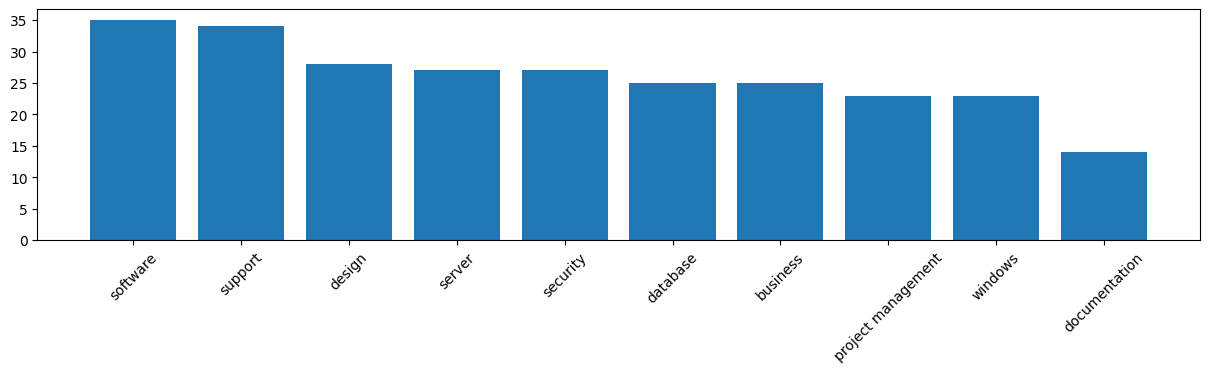

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [24]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [25]:
doc = nlp(text)

In [26]:
# colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"colors": colors}

# displacy.render(doc, style='ent', options=options)

## Task 1: Implementing additional features or improvements inspired by spaCy’s capabilities in natural language processing.

### Task 1.1 identify verbs with their corresponding subjects

In [27]:
from spacy.symbols import nsubj, VERB

# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{implemented, maintain, include, sprint, include, maintain, extranet, report, ipswicth, led, shoot, evaluate, include, solve, include, relate, suites, include, maintain, create, develop, repeated, include}


### Task 1.2  Identifies the root of the sentence, extracts the subject and its subtree

In [28]:
# Loop through the entire document
for sentence in doc.sents:
    # Find the root of the sentence
    roots = [token for token in sentence if token.head == token]
    
    if not roots:
        # Skip sentences without roots
        continue
    
    root = roots[0]
    
    # Extract the subject and its subtree
    subjects = list(root.lefts)
    
    if not subjects:
        # Skip roots without left children
        continue
    
    subject = subjects[0]
    
    # Print information about the subject and its descendants
    for descendant in subject.subtree:
        assert subject is descendant or subject.is_ancestor(descendant)
        print(descendant.text, descendant.dep_, descendant.n_lefts,
              descendant.n_rights,
              [ancestor.text for ancestor in descendant.ancestors])

information compound 0 0 ['technology', 'coordinator', 'overview', 'solve']
technology compound 1 0 ['coordinator', 'overview', 'solve']
coordinator compound 1 0 ['overview', 'solve']
career compound 0 0 ['overview', 'solve']
overview nsubj 2 1 ['solve']
avp compound 0 0 ['director', 'technology', 'strength', 'skill', 'overview', 'solve']
director compound 1 0 ['technology', 'strength', 'skill', 'overview', 'solve']
information compound 0 0 ['technology', 'strength', 'skill', 'overview', 'solve']
technology nmod 2 0 ['strength', 'skill', 'overview', 'solve']
i nmod 0 0 ['engineer', 'strength', 'skill', 'overview', 'solve']
network nmod 0 0 ['engineer', 'strength', 'skill', 'overview', 'solve']
engineer nmod 2 0 ['strength', 'skill', 'overview', 'solve']
extensive amod 0 0 ['experience', 'strength', 'skill', 'overview', 'solve']
experience nmod 1 0 ['strength', 'skill', 'overview', 'solve']
strength nmod 3 0 ['skill', 'overview', 'solve']
excellent amod 0 0 ['skill', 'overview', 'solve'

### Task 1.3 Using spaCy's linguistic annotations to analyze the sentence structure, specifically focusing on the subject and its descendants.

In [29]:
# Loop through the entire document
for sentence in doc.sents:
    # Find the root of the sentence
    roots = [token for token in sentence if token.head == token]

    if not roots:
        # Skip sentences without roots
        continue

    root = roots[0]

    # Extract the subject and its subtree
    subjects = list(root.lefts)

    if not subjects:
        # Skip roots without left children
        continue

    subject = subjects[0]

    # Print information about the subject and its descendants
    print("\nSentence Structure:")
    print(f"Root: {root.text} (POS: {root.pos_}, Dep: {root.dep_})")

    for descendant in subject.subtree:
        assert subject is descendant or subject.is_ancestor(descendant)
        print(f"- Token: {descendant.text} | POS: {descendant.pos_} | Dep: {descendant.dep_}")
        print(f"  - Left children: {descendant.n_lefts}")
        print(f"  - Right children: {descendant.n_rights}")
        print(f"  - Ancestors: {[ancestor.text for ancestor in descendant.ancestors]}")



Sentence Structure:
Root: solve (POS: VERB, Dep: ROOT)
- Token: information | POS: NOUN | Dep: compound
  - Left children: 0
  - Right children: 0
  - Ancestors: ['technology', 'coordinator', 'overview', 'solve']
- Token: technology | POS: NOUN | Dep: compound
  - Left children: 1
  - Right children: 0
  - Ancestors: ['coordinator', 'overview', 'solve']
- Token: coordinator | POS: NOUN | Dep: compound
  - Left children: 1
  - Right children: 0
  - Ancestors: ['overview', 'solve']
- Token: career | POS: NOUN | Dep: compound
  - Left children: 0
  - Right children: 0
  - Ancestors: ['overview', 'solve']
- Token: overview | POS: NOUN | Dep: nsubj
  - Left children: 2
  - Right children: 1
  - Ancestors: ['solve']
- Token: avp | POS: CCONJ | Dep: compound
  - Left children: 0
  - Right children: 0
  - Ancestors: ['director', 'technology', 'strength', 'skill', 'overview', 'solve']
- Token: director | POS: NOUN | Dep: compound
  - Left children: 1
  - Right children: 0
  - Ancestors: ['tech

### Task 1.4 Identifying linguistic features of each token

In [30]:
# Loop through each token in the document
for token in doc:
    # Print various information about the token
    print(
        token.text,         # The original text of the token
        token.lemma_,       # The base or root form of the token's word
        token.pos_,         # Part-of-speech (POS) tag
        token.tag_,         # Detailed POS tag
        token.dep_,         # Syntactic dependency relation
        token.shape_,       # Word shape (capitalization, punctuation, digits)
        token.is_alpha,     # True if the token consists of alphabetic characters
        token.is_stop       # True if the token is a stop word
    )


information information NOUN NN compound xxxx True False
technology technology NOUN NN compound xxxx True False
coordinator coordinator NOUN NN compound xxxx True False
career career NOUN NN compound xxxx True False
overview overview NOUN NN nsubj xxxx True False
avp avp CCONJ CC compound xxx True False
director director NOUN NN compound xxxx True False
information information NOUN NN compound xxxx True False
technology technology NOUN NN nmod xxxx True False
i I PRON PRP nmod x True True
network network NOUN NN nmod xxxx True False
engineer engineer NOUN NN nmod xxxx True False
extensive extensive ADJ JJ amod xxxx True False
experience experience NOUN NN nmod xxxx True False
strength strength NOUN NN nmod xxxx True False
excellent excellent ADJ JJ amod xxxx True False
communication communication NOUN NN compound xxxx True False
skill skill NOUN NN appos xxxx True False
strong strong ADJ JJ amod xxxx True False
problem problem NOUN NN appos xxxx True False
solve solve VERB VB ROOT xxxx

### Task 1.5 Getting morphological information

In [31]:
# Loop through each token in the document
for token in doc:
    # Print morphological information for the token
    print(
        f"Token: {token.text}",           # Token text
        f"Morphological Features: {token.morph}",  # Morphological features
        f"PronType: {token.morph.get('PronType')}"  # PronType information
    )

Token: information Morphological Features: Number=Sing PronType: []
Token: technology Morphological Features: Number=Sing PronType: []
Token: coordinator Morphological Features: Number=Sing PronType: []
Token: career Morphological Features: Number=Sing PronType: []
Token: overview Morphological Features: Number=Sing PronType: []
Token: avp Morphological Features: ConjType=Cmp PronType: []
Token: director Morphological Features: Number=Sing PronType: []
Token: information Morphological Features: Number=Sing PronType: []
Token: technology Morphological Features: Number=Sing PronType: []
Token: i Morphological Features: Case=Nom|Number=Sing|Person=1|PronType=Prs PronType: ['Prs']
Token: network Morphological Features: Number=Sing PronType: []
Token: engineer Morphological Features: Number=Sing PronType: []
Token: extensive Morphological Features: Degree=Pos PronType: []
Token: experience Morphological Features: Number=Sing PronType: []
Token: strength Morphological Features: Number=Sing P

## 7. Let's load the PDF - add some realism

In [32]:
from PyPDF2 import PdfReader

reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()

### 1.6 Finding Names better

In [33]:
entities = get_entities(text)
entities


{'PERSON': 'Ren, Akaranee, W., Java, Chaklam Silpasuwanchai, J., Z., Niksirat, Cheng',
 'GPE': 'Japan, Mobile, Bangkok, Thailand, Silpasuwanchai, KS.',
 'SKILL': 'Algorithms, Python, Computer Science, Engineering, AI, deep learning, question answering, Framework, localization, Google',
 'ORG': 'PyTorch, Data\nStructures, S., Jokinen, GPA, •Asian Institute of Technology Pathumthani, International University Bangkok, •Medical, Education\n•Kochi University of Technology Kochi, Machine/Deep Learning, Natural Language Processing, Software Engineering, Computer Science, Pananookooln, J., Oulasvirta, A., •Sirindhorn International Institute of Technology Pathumthani, Hypothesis Testing, Physical Eng Express, SpringBoot, Department of Statistics, Institute of Technology Pathumthani, Wang, Faculty of Business and Technology, School of Engineering and Technology, Thailand\nFaculty, •Kasetsart University, Social Media, •Non-Invasive Blood Glucose Measuring, Computer-Human Interaction, University o

In [43]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)
pattern = [
    {"POS": "PROPN",  # person's name should be a proper noun
     "OP": "{2}",  # person's name usually consists of 2 parts; first name and last name (in some scenario, 3 if a person has middle name)
     "ENT_TYPE": "PERSON"  # person's name is of 'PERSON' entity type|
    },
]
matcher.add("PERSON NAME", [pattern], greedy="LONGEST")


matches = matcher(doc)
matches.sort(key = lambda x: x[1])

person_names = []

for match in matches:
    person_names.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

person_names = list(set(person_names))
person_names

[('akaranee j.', 'PERSON NAME'),
 ('niksirat ks', 'PERSON NAME'),
 ('wang z.', 'PERSON NAME'),
 ('oulasvirta a.', 'PERSON NAME'),
 ('c. ren', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('jokinen j.', 'PERSON NAME'),
 ('sarcar s.', 'PERSON NAME'),
 ('pananookooln c.', 'PERSON NAME'),
 ('silpasuwanchai c.', 'PERSON NAME')]

In [44]:
entities = []

for match in matches:
    entities.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

entities = list(set(entities))
entities

[('akaranee j.', 'PERSON NAME'),
 ('niksirat ks', 'PERSON NAME'),
 ('wang z.', 'PERSON NAME'),
 ('oulasvirta a.', 'PERSON NAME'),
 ('c. ren', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('jokinen j.', 'PERSON NAME'),
 ('sarcar s.', 'PERSON NAME'),
 ('pananookooln c.', 'PERSON NAME'),
 ('silpasuwanchai c.', 'PERSON NAME')]

### 1.7 Extracting Email and URL and phone number

In [45]:
email_pattern = [{"TEXT": {"REGEX": r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"}}]
matcher.add("EMAIL", [email_pattern])
matcher.add("URL", [[{"LIKE_URL": True}]], greedy="LONGEST")
matcher.add("PHONE NUMBER", [
    [{"ORTH": {"in": ["(", "["]}, "is_digit": True}, {"SHAPE": "dddd"}, {"ORTH": {"in": [")", "]"]}}, {"SHAPE": "dddd"}, {"SHAPE": "dddd"}],
    [{"ORTH": {"in": ["(", "["]}, "is_digit": True}, {"SHAPE": "ddd"}, {"ORTH": {"in": [")", "]"]}}, {"SHAPE": "ddd"}, {"SHAPE": "dddd"}],
    [{"SHAPE": "ddd"}, {"ORTH": "-"}, {"SHAPE": "ddd"}, {"ORTH": "-"}, {"SHAPE": "dddd"}],
    [{"SHAPE": "ddd"}, {"SHAPE": "ddd"}, {"SHAPE": "dddd"}],
])

In [46]:
matches = matcher(doc)
matches.sort(key = lambda x: x[1])

In [47]:
entities = []

for match in matches:
    entities.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

entities = list(set(entities))
entities

[('akaranee j.', 'PERSON NAME'),
 ('http://github.com/chaklam-silpasuwanchai', 'URL'),
 ('niksirat ks', 'PERSON NAME'),
 ('wang z.', 'PERSON NAME'),
 ('oulasvirta a.', 'PERSON NAME'),
 ('c. ren', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('jokinen j.', 'PERSON NAME'),
 ('sarcar s.', 'PERSON NAME'),
 ('pananookooln c.', 'PERSON NAME'),
 ('http://chaklam.com', 'URL'),
 ('silpasuwanchai c.', 'PERSON NAME'),
 ('chaklam@ait.asia', 'EMAIL'),
 ('https://doi.org/10.1145/3359593', 'URL')]

In [41]:
doc = nlp(text)
text = preprocessing(text)
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)

### Updated get entinties

In [48]:
matcher = Matcher(nlp.vocab)
matcher.add("PERSON", [[{"POS": "PROPN", "OP": "{2}", "ENT_TYPE": "PERSON"}]], greedy="LONGEST")
matcher.add("EMAIL", [[{"LIKE_EMAIL": True}]], greedy="LONGEST")
matcher.add("URL", [[{"LIKE_URL": True}]], greedy="LONGEST")
matcher.add("PHONE NUMBER", [
    [{"ORTH": {"in": ["(", "["]}, "is_digit": True}, {"SHAPE": "dddd"}, {"ORTH": {"in": [")", "]"]}}, {"SHAPE": "dddd"}, {"SHAPE": "dddd"}],
    [{"ORTH": {"in": ["(", "["]}, "is_digit": True}, {"SHAPE": "ddd"}, {"ORTH": {"in": [")", "]"]}}, {"SHAPE": "ddd"}, {"SHAPE": "dddd"}],
    [{"SHAPE": "ddd"}, {"ORTH": "-"}, {"SHAPE": "ddd"}, {"ORTH": "-"}, {"SHAPE": "dddd"}],
    [{"SHAPE": "ddd"}, {"SHAPE": "ddd"}, {"SHAPE": "dddd"}],
])

# modified from get_skill function
def get_entities(text):
    
    entities = {}
    doc = nlp(text)

    # detect and capture patterns using matcher in resume text
    matches = matcher(doc)
    matches.sort(key = lambda x: x[1])

    for match in matches:
        pattern_type = nlp.vocab.strings[match[0]]
        if pattern_type in entities:
            entities[pattern_type].append(str(doc[match[1]:match[2]]))
        else:
            entities[pattern_type] = [str(doc[match[1]:match[2]])]

    # capture entities in resume text
    ent_types = ["SKILL", "ORG"]

    for ent in doc.ents:
        ent_type = ent.label_
        if ent_type in ent_types:
            if ent_type in entities:
                entities[ent_type].append(ent.text)
            else:
                entities[ent_type] = [ent.text]


    for ent_type in entities.keys():
        entities[ent_type] = ', '.join(unique_list(entities[ent_type]))
            
    return pd.DataFrame.from_dict(entities, orient="index", columns=["entities"])

def unique_list(x):
    return list(set(x))